In [1]:
using Plots
using Random
using Distributions
using LinearAlgebra
include("pogm_restart.jl") # issues adding MIRT so will use julia file instead
rng = Random.seed!(0)
N = 100
D = 100
d = 10
σ1 = 2
σ2 = 35
goodpts = 10
X = zeros(D,N)
Y = zeros(D,N)
Π = vec(zeros(N,1))
U1 = svd(rand(D,N)).U[:,1:d]
for k = 1:N
    X[:,k] = U1*U1'*rand(Uniform(-100,100),D)
end
for j=1:N
        if (j<= goodpts)
            Y[:,j] = X[:,j] + rand(Normal(0,σ1),D)
            Π[j] = σ1^2
        else
            Y[:,j] = X[:,j] + rand(Normal(0,σ2),D)
            Π[j] = σ2^2
        end
end

In [4]:
function HPCA_POGM(Y, λr, w, N, rank, ϵ, x0)
    #objective = (X,Z,λr,Π) -> λr*nucnorm(X) + (1/2)*norm(Z*(Diagonal(Π.^-0.5)), 2)
    Π = w.^-1
    Lf = maximum(Π)
    Π = Diagonal(Π)
    grad = K -> -1*(Y-K)*Π
    soft = (x,t) -> sign.(x) .* max.(abs.(x) .- t, 0)
    function pssvt(x,t,N)
        U,S,V = svd(x)
        S[(N+1):end] = soft.(S[(N+1):end],t)
        return U*diagm(S)*V'
    end
    prox1 = (z,c) -> pssvt(z, c*λr, N)
    K, _ = pogm_restart(x0, x -> 0, grad, Lf ; g_prox=prox1, eps=ϵ) # objective(x,Y-x,λr,w)
    U = svd(K).U[:,1:rank]
    return U
end
function HPCA_ADMM(Y, λr, w, N, μ, ρ, d, U_init)
    #X = zeros(size(Y))
    #Z = zeros(size(Y))
    X = deepcopy(U_init*U_init'*Y)
    Z = deepcopy(Y-X)
    Π = Diagonal(w.^-1)
    #Λ = zeros(size(Y))
    Λ2 = sign.(Y)
    Λ = deepcopy(Λ2 ./ (max(opnorm(Λ2), (1/λr)*norm(Λ2, Inf))))
    normY = norm(Y,2)
    count = 0
    soft = (x,t) -> sign.(x) .* max.(abs.(x) .- t, 0)
    function pssvt(x,t,N)
        U,S,V = svd(x)
        S[(N+1):end] = soft.(S[(N+1):end],t)
        return U*diagm(S)*V'
    end
    #while norm(Y-X-Z,2)/normY > 1e-6
    #while norm(X-X0)/norm(X0) > 1e-6
    for i = 1:2000
        #X0 = X
        X = pssvt(Y-Z+(1/μ)*Λ, λr/μ,N)
        Z = μ*(Y-X+(1/μ)*Λ)*inv(Π+μ*I)
        Λ = Λ + μ*(Y-X-Z)
        μ = ρ*μ
        count = count + 1
    end
    U = svd(X).U[:,1:d]   
    return U
end
function weightedPCA(Y , w, k)
    L = unique(w)
    Σ = zeros(size(Y)[1], size(Y)[1])
    for i=1:length(L)
        ind = findall(x -> x == L[i], w)
        Σ = Σ + L[i]*(Y[:,ind]*Y[:,ind]')
    end
    U = reverse(eigvecs(Σ), dims=2)
    Ȳ = reshape(shuffle(Y[:]), size(Y))
    U_Y = svd(Y).S
    U_Ȳ = svd(Ȳ).S
    #k = floor(Int, norm(U_Y .> U_Ȳ, 0))
    return U[:,1:k] #, k
end
U_WPCA = weightedPCA(Y,Π.^-1,d)
error_wpca = norm(U_WPCA*U_WPCA' - U1*U1', 2)/norm(U1*U1', 2)
using HePPCAT
heppCAT_matrix = []
push!(heppCAT_matrix, Y[:,1:goodpts])
push!(heppCAT_matrix, Y[:,(goodpts+1):end])
homoPCA = heppcat(heppCAT_matrix,d,0)   # init is homoscedastic PPCA
knownvar = deepcopy(homoPCA)
knownvar.v[1] = σ1^2
knownvar.v[2] = σ2^2
heppCAT_known = heppcat(heppCAT_matrix,d,1000;init=knownvar,vknown=true);
error_heppcat = norm(heppCAT_known.U*heppCAT_known.U' - U1*U1', 2)/norm(U1*U1', 2)
error_homoppca = norm(homoPCA.U*homoPCA.U' - U1*U1', 2)/norm(U1*U1', 2)

0.8902024700565202

In [5]:
λr = vcat(0:0.1:1,1:0.5:10)
error_hpca_zero = zeros(size(λr))
λr[1] = 0.001
for i=1:length(λr)
    println(i)
    flush(stdout)
    U_HPCA = HPCA_ADMM(Y, λr[i], Π, 10, 0.01, 1.005, d, zeros(100,10)) 
    error_hpca_zero[i] = norm(U_HPCA*U_HPCA' - U1*U1',2)/norm(U1*U1',2)
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [6]:
λr = vcat(0:0.1:1,1:0.5:10)
error_hpca_ppca = zeros(size(λr))
λr[1] = 0.001
for i=1:length(λr)
    println(i)
    flush(stdout)
    U_RPCA = HPCA_ADMM(Y, λr[i], Π, 10, 0.01, 1.005, d, homoPCA.U)   
    error_hpca_ppca[i] = norm(U_RPCA*U_RPCA' - U1*U1',2)/norm(U1*U1',2)
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [8]:
λr = vcat(0:0.1:1,1:0.5:10)
error_hpca_wpca = zeros(size(λr))
λr[1] = 0.001
for i=1:length(λr)
    println(i)
    flush(stdout)
    U_HPCA = HPCA_ADMM(Y, λr[i], Π, 10, 0.01, 1.005, d, U_WPCA)  
    error_hpca_wpca[i] = norm(U_HPCA*U_HPCA' - U1*U1',2)/norm(U1*U1',2)
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


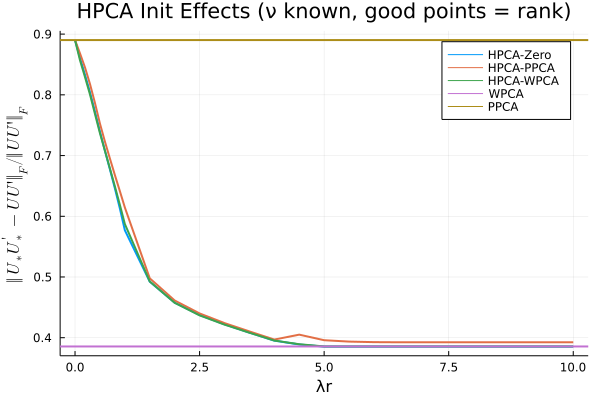

In [12]:
using LaTeXStrings
plot(λr, error_hpca_zero, label="HPCA-Zero", title="HPCA Init Effects (ν known, good points = rank)", xlabel="λr", ylabel=L"\Vert U_{*} U_{*}^{'}- UU' \Vert_F/ \Vert UU' \Vert_F",linewidth=2)
plot!(λr, error_hpca_ppca, label="HPCA-PPCA",linewidth=2)
plot!(λr, error_hpca_wpca, label="HPCA-WPCA",linewidth=2)
hline!([error_wpca], label="WPCA", linewidth=2)
hline!([error_homoppca], label="PPCA", linewidth=2)
#savefig("HPCA_KNOWN_INIT.pdf")